In [2]:
!pip install easydict

In [3]:

import os
import sys
import cv2
import json
import time
import math
from tqdm import tqdm

import torch
import torch.utils.data as data
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import argparse

HOME_ = '/data2/projects/chaeyun/VerbCentric_RIS'
sys.path.append(HOME_)


from easydict import EasyDict
from functools import partial

from engine.engine import train, validate 
from utils.dataset import RefDataset as origDataset
from utils.simple_tokenizer import SimpleTokenizer as _Tokenizer

train_set_pth = '/data2/projects/chaeyun/VerbCentric_RIS/datasets/anns/refcocog_u/train.json'
val_set_pth = '/data2/projects/chaeyun/VerbCentric_RIS/datasets/anns/refcocog_u/val.json'
test_set_pth = '/data2/projects/chaeyun/VerbCentric_RIS/datasets/anns/refcocog_u/test.json'
mask_root = '/data2/projects/chaeyun/VerbCentric_RIS/datasets/masks/refcocog_u'

# ORIGINAL MODEL CONFIG AND WEIGHTS
orig_config_path = '/data2/projects/chaeyun/VerbCentric_RIS/config/cris_r50.yaml'
orig_model_path = '/data2/projects/chaeyun/VerbCentric_RIS/exp/CRIS_R50/best_model_miou.pth'

# NEW MODEL CONFIG AND WEIGHTS
new_config_path = '/data2/projects/chaeyun/VerbCentric_RIS/config/cris_verbonly_b64_nopos.yaml'
exo_name = 'ACE_hp10_m08_tmp005_b64_v1'
exo_name2 = 'ACE_hp10_m10_tmp005_b64_v1'
exo_name3 = 'ACE_hp10_m15_tmp005_b64_v1'

# /data2/projects/chaeyun/VerbCentric_RIS/exp/ACE_hp10_m08_tmp005_b64_v1/
new_model_path = f'/data2/projects/chaeyun/VerbCentric_RIS/exp/{exo_name}/best_model_miou.pth'
new_model_path2=f'/data2/projects/chaeyun/VerbCentric_RIS/exp/{exo_name2}/best_model_miou.pth'
new_model_path3=f'/data2/projects/chaeyun/VerbCentric_RIS/exp/{exo_name3}/best_model_miou.pth'

# IMAGE MIN AND STD 
img_mean = np.array([0.48145466, 0.4578275,0.40821073]).reshape(1, 1, 3)
img_std = np.array([0.26862954, 0.26130258,0.27577711]).reshape(1, 1, 3)


os.environ['CUDA_VISIBLE_DEVICES'] = '3'

ModuleNotFoundError: No module named 'utils.dataset'; 'utils' is not a package

In [4]:
pwd

'/data2/projects/chaeyun/LAVT-RIS'

In [128]:
import utils.config as config
from utils.dataset_verbonly import RefDataset
from utils.misc import (init_random_seed, set_random_seed, setup_logger,
                        worker_init_fn)

from model_ import build_segmenter_original, build_segmenter_pos_rev2
from model_.clip import build_model

from .segmenter import CRIS
from .segmenter_verbonly import CRIS_PosOnly
from .segmenter_verbonly_fin import CRIS_PosOnly_rev
from .segmenter_verbonly_ver3 import CRIS_PosOnly_ver3


In [129]:
parser = argparse.ArgumentParser(
    description='Pytorch Referring Expression Segmentation')
parser.add_argument('--config',
                    default=orig_config_path,
                    type=str,
                    help='config file')
parser.add_argument('--opts',
                    default=None,
                    nargs=argparse.REMAINDER,
                    help='override some settings in the config.')

args = parser.parse_args([])

cfg = config.load_cfg_from_cfg_file(orig_config_path)
cfg.metric_learning = True
args = EasyDict(cfg)
print(args)
original_model, original_param_list = build_segmenter_pos_rev2(args)



{'dataset': 'refcocog_u', 'train_lmdb': '/home/seunghoon/research/VerbCentric_RIS/datasets/lmdb/refcocog_u/train.lmdb', 'train_split': 'train', 'val_lmdb': '/home/seunghoon/research/VerbCentric_RIS/datasets/lmdb/refcocog_u/val.lmdb', 'val_split': 'val', 'mask_root': '/home/seunghoon/research/VerbCentric_RIS/datasets/masks/refcocog_u', 'clip_pretrain': '/home/seunghoon/research/VerbCentric_RIS/pretrain/RN50.pt', 'input_size': 416, 'word_len': 22, 'word_dim': 1024, 'vis_dim': 512, 'fpn_in': [512, 1024, 1024], 'fpn_out': [256, 512, 1024], 'sync_bn': True, 'freeze': True, 'train_text_encoder': False, 'train_visual_encoder': False, 'num_layers': 3, 'num_head': 8, 'dim_ffn': 2048, 'dropout': 0.1, 'intermediate': False, 'workers': 4, 'workers_val': 4, 'epochs': 50, 'milestones': [35], 'start_epoch': 0, 'batch_size': 64, 'batch_size_val': 64, 'base_lr': 0.0001, 'lr_decay': 0.1, 'lr_multi': 0.1, 'weight_decay': 0.0, 'max_norm': 0.0, 'manual_seed': 0, 'print_freq': 100, 'metric_learning': True, 

2024-12-10 01:09:00.796 | INFO     | model_:build_segmenter_pos_rev2:19 - Backbone with decay=325, Head=124


In [130]:
parser = argparse.ArgumentParser(
    description='Pytorch Referring Expression Segmentation')
parser.add_argument('--config',
                    default=new_config_path,
                    type=str,
                    help='config file')
parser.add_argument('--opts',
                    default=None,
                    nargs=argparse.REMAINDER,
                    help='override some settings in the config.')

args = parser.parse_args([])

cfg = config.load_cfg_from_cfg_file(new_config_path)
cfg.metric_learning = True
args = EasyDict(cfg)
print(args)
new_model, new_param_list = build_segmenter_pos_rev2(args)

{'dataset': 'refcocog_u', 'train_lmdb': '/home/seunghoon/research/VerbCentric_RIS/datasets/lmdb/refcocog_u/train.lmdb', 'train_split': 'train', 'val_lmdb': '/home/seunghoon/research/VerbCentric_RIS/datasets/lmdb/refcocog_u/val.lmdb', 'val_split': 'val', 'mask_root': '/home/seunghoon/research/VerbCentric_RIS/datasets/masks/refcocog_u', 'clip_pretrain': '/home/seunghoon/research/VerbCentric_RIS/pretrain/RN50.pt', 'input_size': 416, 'word_len': 22, 'word_dim': 1024, 'vis_dim': 512, 'fpn_in': [512, 1024, 1024], 'fpn_out': [256, 512, 1024], 'sync_bn': True, 'freeze': True, 'train_text_encoder': False, 'train_visual_encoder': False, 'num_layers': 3, 'num_head': 8, 'dim_ffn': 2048, 'dropout': 0.1, 'intermediate': False, 'workers': 0, 'workers_val': 0, 'epochs': 50, 'milestones': [35], 'start_epoch': 0, 'batch_size': 64, 'batch_size_val': 64, 'base_lr': 0.0001, 'textft_lr': 1e-05, 'visft_lr': 0.0, 'lr_decay': 0.1, 'lr_multi': 0.1, 'weight_decay': 0.0, 'max_norm': 0.0, 'manual_seed': 0, 'print_

2024-12-10 01:09:02.415 | INFO     | model_:build_segmenter_pos_rev2:19 - Backbone with decay=325, Head=124


### Define dataloader and util functions

In [131]:
init_fn = partial(worker_init_fn,
                        num_workers=args.workers,
                        rank=args.rank,
                        seed=args.manual_seed)
val_data = origDataset(lmdb_dir=args.val_lmdb,
                            mask_dir=args.mask_root,
                            dataset=args.dataset,
                            split=args.val_split,
                            mode='val',
                            input_size=args.input_size,
                            word_length=args.word_len,
                            args=args)
val_loader = data.DataLoader(val_data,
                           batch_size=32,
                           shuffle=False,
                           num_workers=args.workers_val,
                           pin_memory=True,
                           drop_last=True)

train_data = RefDataset(lmdb_dir=args.train_lmdb,
                            mask_dir=args.mask_root,
                            dataset=args.dataset,
                            split=args.train_split,
                            mode='train',
                            input_size=args.input_size,
                            word_length=args.word_len,
                            args=args)
train_loader = data.DataLoader(train_data,
                            batch_size=32,
                            shuffle=False,
                            num_workers=args.workers,
                            pin_memory=True,
                            worker_init_fn=init_fn,
                            drop_last=True)
# detokenizer
tokenizer = _Tokenizer()


In [132]:
for data in train_loader:
    img, word_vec, mask, hardpos = data
    print(img.shape, word_vec.shape, mask.shape, hardpos.shape)
    print(hardpos)
    break

torch.Size([32, 3, 416, 416]) torch.Size([32, 22]) torch.Size([32, 416, 416]) torch.Size([32, 22])
tensor([[    0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [49406,  1265, 11688, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [49406,  1960,   320, 31777,  8172, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [49406,  1312,   536, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0],
        [49406,  7435,   320,  3101,  2972, 49407,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,

### Load pretrained models

In [133]:
# get current device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)

device: cuda


In [134]:
original_checkpoint = torch.load(orig_model_path, map_location='cuda')
args.start_epoch = original_checkpoint['epoch']
best_IoU = original_checkpoint["best_iou"]
best_oIoU = original_checkpoint["best_oiou"]
original_model = torch.nn.DataParallel(original_model)
original_model.load_state_dict(original_checkpoint['state_dict'])
original_model = original_model.to(device)
#original_model.eval()


new_checkpoint = torch.load(new_model_path, map_location='cuda')
args.start_epoch = new_checkpoint['epoch']
best_IoU = new_checkpoint["best_iou"]
best_oIoU = new_checkpoint["best_oiou"]
new_model = torch.nn.DataParallel(new_model)
new_model.load_state_dict(new_checkpoint['state_dict'])
new_model = new_model.to(device)
#new_model.eval()

/tmp/ipykernel_1173351/383024302.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  original_checkpoint = torch.load(orig_model_path, map_location='cuda')
/tmp/ipykernel_11

In [135]:
# similarity matrix calc
def calc_sim(embeddings):
    # embeddings : (b, c, h, w)
    print("embedding shape: ", embeddings.size())
    if len(embeddings.size()) == 3:
        b, c, hw = embeddings.size()
        embeddings = embeddings.view(b, c, -1).mean(dim=2)
    
    # cosine similarity
    sim = F.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=2)
    return sim

def draw_result(imgs, preds, masks, texts):
    for img, pred, mask,  orig_text in zip(imgs, preds, masks, texts):
        # drop zeros of text
        orig_text = orig_text[orig_text != 0]
        orig_text = orig_text[1:-1]
        orig_text = tokenizer.decode(orig_text)
        img = img.permute(1, 2, 0).cpu().numpy()
        # unscale using image_mean and image_std
        img = img * img_std + img_mean
        # and clamp to [0, 1]
        img = np.clip(img, 0, 1)

        pred = pred.cpu().numpy()
        mask = mask.cpu().numpy()
        plt.title(f"text: {orig_text}")
        plt.imshow(img)
        plt.imshow(pred, alpha=0.5)
        #plt.imshow(mask, alpha=0.5)
        plt.show()


def return_mask(emb_distance, positive_verbs, negative_verbs, posneg_verbs=None, verb_mask=None):

    assert torch.sum(verb_mask) == torch.sum(positive_verbs + negative_verbs), "Verb mask does not match the sum of positive and negative verbs."
    assert len(positive_verbs) == len(negative_verbs), "Positive and negative verbs do not have the same length."

    B_, B_ = emb_distance.shape
    positive_mask = torch.zeros_like(emb_distance)
    negative_mask = torch.ones_like(emb_distance)
    hard_negative_mask = torch.zeros_like(emb_distance)
    positive_mask.fill_diagonal_(1)

    # print("positive verbs: ", positive_verbs)
    # print("negative verbs: ", negative_verbs)
    # print("emb shape: ", emb_distance.shape)

    if B_ < len(verb_mask):
        # Considering only verbs that pass the verb_mask filter
        positive_verbs = torch.tensor(positive_verbs)[verb_mask]
        negative_verbs = torch.tensor(negative_verbs)[verb_mask]

        # Exclude hard negatives from both masks (diagonal)
        for i in range(B_):
            if negative_verbs[i] == 1:
                positive_mask[i, i] = 0
                negative_mask[i, i] = 0
                # Set the entire row and column for the hard negative, except the diagonal
                hard_negative_mask[i, :] = 1  # Mark the i-th row
                hard_negative_mask[:, i] = 1  # Mark the i-th column
                hard_negative_mask[i, i] = 0  # Ensure diagonal element (i, i) is 0

        i = 0
        while i < B_:
            if positive_verbs[i] == 1:  
                if i + 1 < B_ and positive_verbs[i + 1] == 1:
                    positive_mask[i, i + 1] = 1
                    positive_mask[i + 1, i] = 1
                i += 2 
            else:
                i += 1
    else:
        # Exclude hard negatives from both masks (diagonal)
        for i in range(B_):
            if negative_verbs[i] == 1:
                positive_mask[i, i] = 0
                negative_mask[i, i] = 0
                # Set the entire row and column for the hard negative, except the diagonal
                hard_negative_mask[i, :] = 1  # Mark the i-th row
                hard_negative_mask[:, i] = 1  # Mark the i-th column
                hard_negative_mask[i, i] = 0  # Ensure diagonal element (i, i) is 0

        # Apply the positive pairs logic similarly as above
        i = 0
        while i < B_:
            if positive_verbs[i] == 1 and i + 1 < B_ and positive_verbs[i + 1] == 1:
                positive_mask[i, i + 1] = 1
                positive_mask[i + 1, i] = 1
                i += 2
            else:
                i += 1

    negative_mask = negative_mask - positive_mask
    negative_mask[hard_negative_mask.bool()] = 0  # Set hard negative indices to 0 in negative_mask
    # print("positive mask: ", positive_mask)
    # print("negative mask: ", negative_mask)
    return positive_mask, negative_mask, hard_negative_mask


def infer_result(model_in_use, data_loader, vis = False, trial = 25):
    with torch.no_grad(): 
        sims = []
        pos_masks = []
        neg_masks = []
        iter = 0
        for i, (imgs, texts, target, hardpos) in enumerate(train_loader):
            # data
            imgs = imgs.cuda(non_blocking=True)
            texts = texts.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True).unsqueeze(1)
            hardpos = hardpos.cuda(non_blocking=True)
            #print(hardpos)
            #print("shapes: ", imgs.shape, texts.shape, target.shape, hardpos.shape)

            # inference
            # preds, tgts, loss, embeddings = model_in_use(image, text, target, hardpos)
            preds, tgts, loss, sim_matrix, posverb_mask, negverb_mask = model_in_use(imgs, texts, target, hardpos)
            verb_mask = posverb_mask + negverb_mask 
            positive_mask, negative_mask, hard_negative_mask = return_mask(sim_matrix, posverb_mask, negverb_mask, verb_mask=verb_mask)
            # print("mask shapes: ", positive_mask.shape, negative_mask.shape)
            # print("pos mask: ", positive_mask)
            # print("neg mask: ", negative_mask)
            # print("similarity matrix: ", sim_matrix)

            # calc similarity matrix
            #sim = calc_sim(embeddings)
            #print(sim_matrix.size())
            #print(posverb_mask)
            sims.append(sim_matrix.detach().cpu().numpy())
            pos_masks.append(positive_mask.detach().cpu().numpy())
            neg_masks.append(negative_mask.detach().cpu().numpy())
            preds = torch.sigmoid(preds)
            if preds.shape[-2:] != imgs.shape[-2:]:
                    preds = F.interpolate(preds,
                                        size=imgs.shape[-2:],
                                        mode='bicubic',
                                        align_corners=True).squeeze(1)
            # overlay image and preds mask
            imgs = imgs.detach().cpu()
            texts = texts.detach().cpu()
            preds = preds.detach().cpu()
            
            #masks = masks.detach().cpu()
            # texts to numpy
            texts = texts.numpy()
            
            if vis:
                draw_result(imgs, preds, tgts, texts)
            # draw_result(imgs, preds, masks, texts)
            iter+=1
            if iter > trial:
                break
        return sims, pos_masks, neg_masks   

In [ ]:
sims_orig, positive_mask_orig, negative_mask_orig = infer_result(original_model, train_loader, vis=False, trial=100)
sims_new, positive_mask_new, negative_mask_new = infer_result(new_model, train_loader, vis=False, trial=100)

/tmp/ipykernel_1173351/1865868274.py:13: RuntimeWarning: invalid value encountered in arccos
  sim = np.arccos(sim)


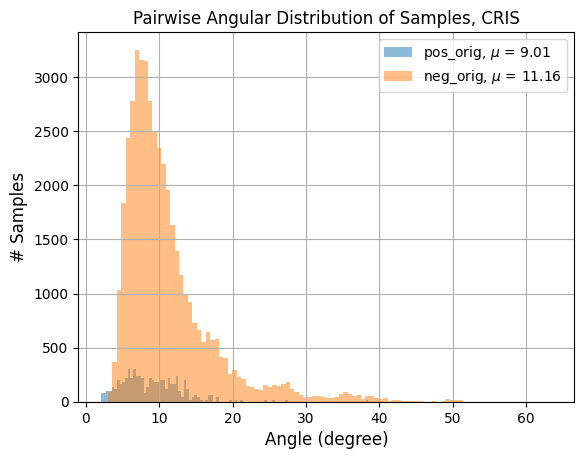

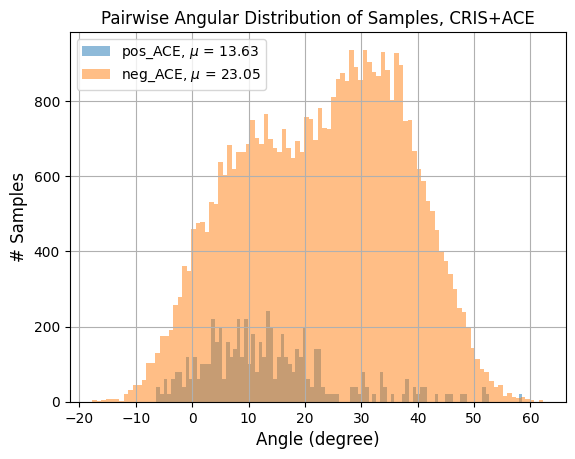

In [ ]:
angle_vals = []

def get_posneg_sim(sims, poses, negs, combined=False):
    rad_ = 180 / math.pi
    pos_vals = []
    neg_vals = []
    combined_vals = []
    for sim, pos_, neg_ in zip(sims, poses, negs):
        #print(sim.shape, pos_.shape, neg_.shape)
        # make diagonals to 0
        pos_ = pos_ - np.eye(pos_.shape[0])
        neg_ = neg_ - np.eye(neg_.shape[0])
        sim = np.arccos(sim)
        # append, except for values with <0.05 
        pos_vals.extend(sim[pos_ == 1].flatten())
        neg_vals.extend(sim[neg_ == 1].flatten())
        if combined :
            combined_vals.extend(sim[pos_ == 1].flatten())
            combined_vals.extend(sim[neg_ == 1].flatten())
    
    if combined : 
        return np.array(pos_vals) * rad_, np.array(neg_vals) * rad_, np.array(combined_vals) * rad_
    else : 
        return np.array(pos_vals) * rad_, np.array(neg_vals) * rad_

# pos_vals_orig, neg_vals_orig = get_posneg_sim(sims_orig, positive_mask_orig, negative_mask_orig)
# pos_vals_new, neg_vals_new = get_posneg_sim(sims_new, positive_mask_new, negative_mask_new)

pos_vals_orig, neg_vals_orig, combined_vals_orig = get_posneg_sim(sims_orig, positive_mask_orig, negative_mask_orig, combined=True)
pos_vals_new, neg_vals_new, combined_vals_new = get_posneg_sim(sims_new, positive_mask_new, negative_mask_new, combined=True)




plt.hist(pos_vals_orig.repeat(10), bins=100, label=f'pos_orig, $\mu$ = {np.mean(pos_vals_orig):.2f}', alpha=0.5)
plt.hist(neg_vals_orig, bins=100, label=f'neg_orig, $\mu$ = {np.mean(neg_vals_orig):.2f}', alpha=0.5)
plt.xlabel('Angle (degree)', fontsize=12)
plt.ylabel('# Samples', fontsize=12)
plt.title('Pairwise Angular Distribution of Samples, CRIS')
plt.grid()
plt.legend()
plt.show()

plt.hist(90 - pos_vals_new.repeat(10), bins=100, label=f'pos_ACE, $\mu$ = {90 - np.mean(pos_vals_new):.2f}', alpha=0.5)
plt.hist(90 - neg_vals_new, bins=100, label=f'neg_ACE, $\mu$ = {90 - np.mean(neg_vals_new):.2f}', alpha=0.5)
plt.xlabel('Angle (degree)', fontsize=12)
plt.ylabel('# Samples', fontsize=12)
plt.title('Pairwise Angular Distribution of Samples, CRIS+ACE')
plt.grid()
plt.legend()
plt.show()

# for sim in sims:
#     # get off-diagonal elements
#     sim = sim
#     # arccos
#     sim = np.arccos(sim)
#     # append, except for values with <0.05 
#     sim = sim[sim > 0.05]
#     angle_vals.extend(sim.flatten())

# angle_vals_new = []
# for sim in sims_new:
#     # get off-diagonal elements
#     sim = sim
#     # arccos
#     sim = np.arccos(sim)
#     # append, except for values with <0.05 
#     sim = sim[sim > 0.05]
#     angle_vals_new.extend(sim.flatten())

# plt.hist(angle_vals, bins=100, label='original', alpha=0.5)
# plt.hist(angle_vals_new, bins=100, label='new', alpha=0.5)
# plt.legend()
# plt.show()